# Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

# Set Variables

In [19]:
CULL_FRACTION = 1 #amount of dataset to use
TRAIN_FRACTION = 0.8 #train fraction
LOAD = False #tries to load existing model
EPOCHS = 10000
SAMPLES = 10000 #no of samples to generate
model_path = "models/model.pkl"

# Load Dataset

In [7]:
df = pd.read_csv("real_data.csv").set_index("building_id")
df

,building_type,sqft,yearbuilt,numberoffloors,airTemperature,dewTemperature,precipDepth1HR,power_consumption
building_id,,,,,,,,
0,Office,408000.0,2010.0,0.0,15.661433,8.351597,0.697141,599.714626
1,Office,64743.0,0.0,0.0,13.168836,6.213631,0.836181,140.671052
2,College Laboratory,131710.0,1991.0,0.0,25.075584,3.955005,0.139824,186.922692
3,Education,75228.0,1993.0,4.0,15.102759,10.010696,0.433825,118.826085
4,Police Station,43955.0,1978.0,0.0,15.661433,8.351597,0.697141,97.534061
...,...,...,...,...,...,...,...,...
1573,Primary/Secondary Classroom,30613.0,1976.0,4.0,11.000171,8.430964,0.000000,8.840769
1574,Other - Recreation,3133.0,0.0,0.0,15.661433,8.351597,0.697141,1.756642
1575,Office,850354.0,1989.0,0.0,15.661433,8.351597,0.697141,2128.527409


# Pre Processing

In [8]:
cull_df = df.sample(frac=CULL_FRACTION).reset_index(drop=True)

train_data, test_data = train_test_split(cull_df, train_size=TRAIN_FRACTION)

print(train_data.shape, test_data.shape)

(1262, 8) (316, 8)


# GAN Training

In [20]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(train_data) 

if LOAD:
    synthesizer = CTGANSynthesizer.load(filepath=model_path)
else:
    synthesizer = CTGANSynthesizer(
        metadata,
        enforce_rounding=True,
        epochs=EPOCHS,
        verbose=True
    )
    synthesizer.fit(train_data)

C:\Users\raaja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sdv\single_table\base.py:86: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Gen. (-0.18) | Discrim. (0.15): 100%|████████████████████████████████████████████| 10000/10000 [11:37<00:00, 14.33it/s]


In [30]:
samples = synthesizer.sample(
    num_rows=SAMPLES,
    batch_size=1000
)
samples

Sampling rows: 100%|██████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 13742.44it/s]


,building_type,sqft,yearbuilt,numberoffloors,airTemperature,dewTemperature,precipDepth1HR,power_consumption
0,Academic,134471.0,24.0,0.0,10.318171,3.233350,12.283343,382.612082
1,Classroom,68960.0,2004.0,0.0,22.323600,17.261222,1.228208,189.324335
2,Student Union,21683.0,9.0,0.0,22.560867,14.499050,0.768065,52.608193
3,Park,3807.0,27.0,1.0,22.168215,17.139511,1.265239,9.726767
4,"Community Center, Community Centers",23064.0,26.0,1.0,22.863426,17.261222,1.112970,94.093402
...,...,...,...,...,...,...,...,...
9995,"Community Center, Community Centers",13869.0,12.0,1.0,22.474502,17.261222,1.218370,27.733924
9996,Fire Station,13565.0,1948.0,2.0,15.552632,8.495808,0.054409,25.241228
9997,Primary/Secondary Classroom,74588.0,1969.0,2.0,10.743060,8.288789,0.024862,8.685739
9998,Academic,95055.0,1980.0,0.0,9.147384,3.040716,11.393195,165.700012


# Evaluation

In [31]:
eval_real = test_data.copy()
eval_fake = samples.copy()

le = LabelEncoder()
eval_real['building_type'] = le.fit_transform(test_data['building_type'])
eval_fake['building_type'] = le.fit_transform(samples['building_type'])

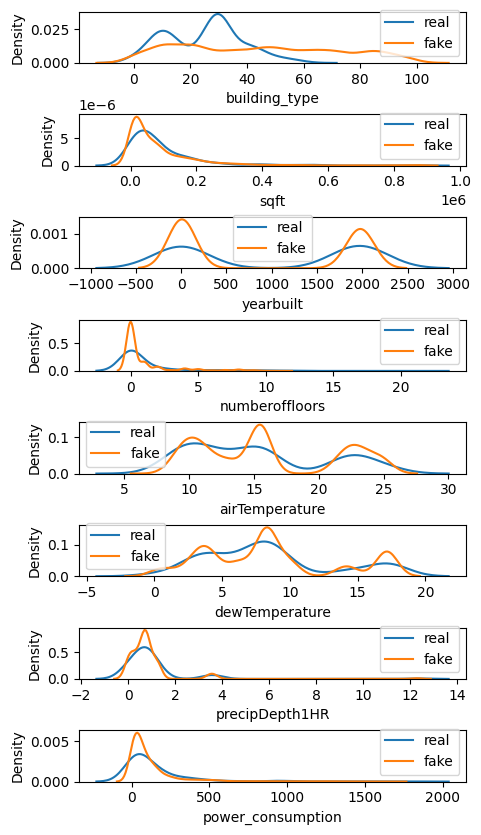

In [32]:
fig = plt.figure(figsize=(5,10))
fig.subplots_adjust(hspace=1, wspace=0.4)

for n,cat in enumerate(eval_real.columns):
    ax = fig.add_subplot(8, 1, n+1)
    sns.kdeplot(eval_real[cat], label = 'real', ax=ax)
    sns.kdeplot(eval_fake[cat], label = 'fake', ax = ax)
    plt.legend()

<Axes: >

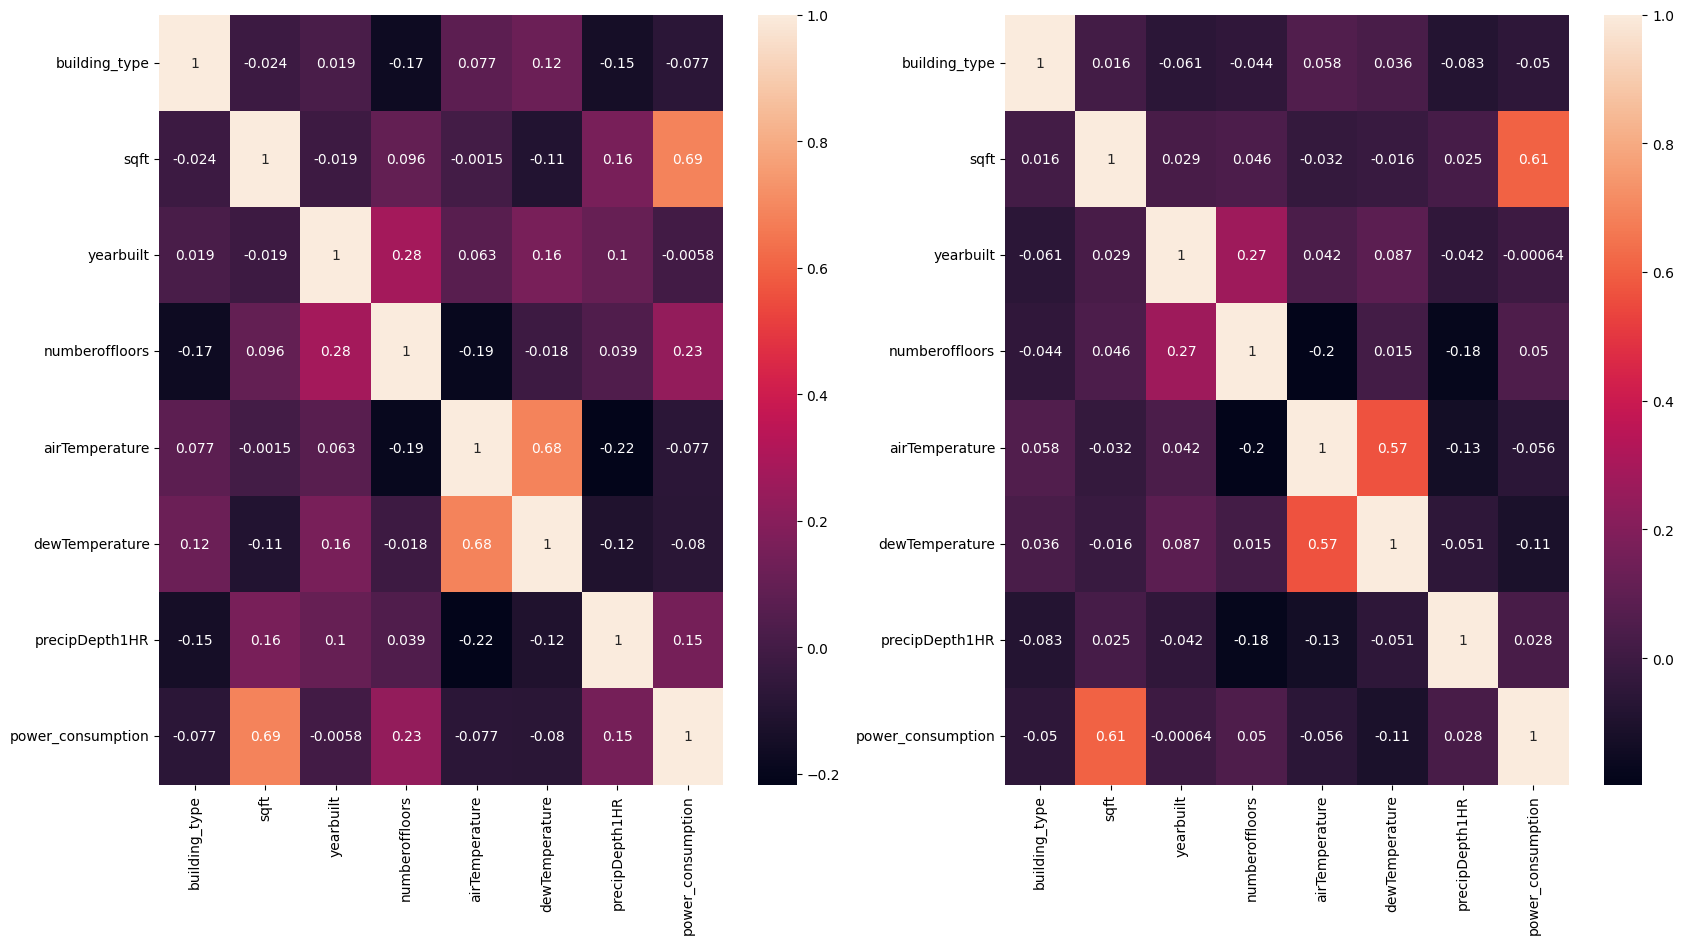

In [33]:
fig_corr = plt.figure(figsize=(20,10))
ax = fig_corr.add_subplot(1, 2, 1)
sns.heatmap(eval_real.corr(), annot=True, ax=ax)
ax = fig_corr.add_subplot(1, 2, 2)
sns.heatmap(eval_fake.corr(), annot=True, ax=ax)

# Save Model

In [34]:
synthesizer.save(filepath=model_path)

# Save Generated Dataset

In [35]:
samples.to_csv("generated_data.csv")